some prereading: 

[Approaching (Almost) Any Machine Learning Problem](http://blog.kaggle.com/2016/07/21/approaching-almost-any-machine-learning-problem-abhishek-thakur/)


# Step 1 - get data

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# https://stackoverflow.com/a/50970152
pd.core.common.is_list_like = pd.api.types.is_list_like
# you have to install pandas_datareader module i Anaconda Navigator:
# http://docs.anaconda.com/anaconda/navigator/tutorials/manage-packages/
from pandas_datareader.data import DataReader

In [2]:
# Define timeframe of stocks we retreive 
end = dt.datetime.now() 
start = end - dt.timedelta(days=5*365)

In [3]:
# Use DataReader to get Apples stock data from IEX https://iextrading.com/developer/
# df = DataReader('AAPL','iex', start, end)
df = DataReader('MU','iex', start, end)
df.head()

5y


,open,high,low,close,volume
date,,,,,
2013-10-03,17.94,18.100,17.37,18.015,58897371
2013-10-04,18.08,18.545,18.01,18.470,48056969
2013-10-07,18.77,18.850,18.48,18.485,61944447
2013-10-08,18.60,18.650,17.73,17.925,57086352
2013-10-09,18.03,18.450,17.15,18.150,67665565


In [4]:
df.tail()

,open,high,low,close,volume
date,,,,,
2018-09-24,44.20,45.6500,43.860,45.16,36918937
2018-09-25,45.10,45.4606,44.020,44.64,32547450
2018-09-26,44.29,44.7600,43.960,44.35,30299841
2018-09-27,44.23,45.5200,44.046,44.99,26952377
2018-09-28,44.65,45.6100,44.490,45.23,28080411


In [5]:
df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
df.index

DatetimeIndex(['2013-10-03', '2013-10-04', '2013-10-07', '2013-10-08',
               '2013-10-09', '2013-10-10', '2013-10-11', '2013-10-14',
               '2013-10-15', '2013-10-16',
               ...
               '2018-09-17', '2018-09-18', '2018-09-19', '2018-09-20',
               '2018-09-21', '2018-09-24', '2018-09-25', '2018-09-26',
               '2018-09-27', '2018-09-28'],
              dtype='datetime64[ns]', name='date', length=1257, freq=None)

In [6]:
#Export to csv file
# df.to_csv(path_or_buf='MU.csv')

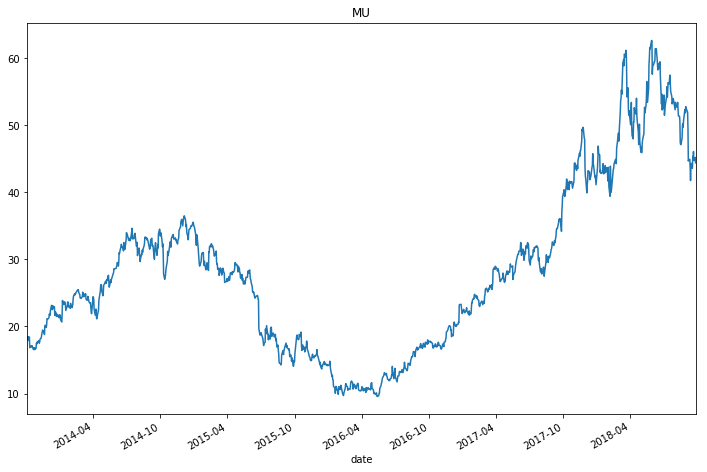

In [7]:
#Plot close column
df.close.plot(figsize=(12,8), title='MU')

In [8]:
# Plot OHLC graph by plotly
import plotly.plotly as py
import plotly.graph_objs as go

trace = go.Ohlc(x=df.index, 
                open=df.open, 
                high=df.high, 
                low=df.low, 
                close=df.close)

data = [trace]
py.iplot(data, filename='simple_ohlc')

# plotly.tools.set_credentials_file(username='hongng2304', api_key='XTeLjIUBvYxEy2wM5c7j')

# Step 2 - implement 2 features and visualize the price and the features in the same graph

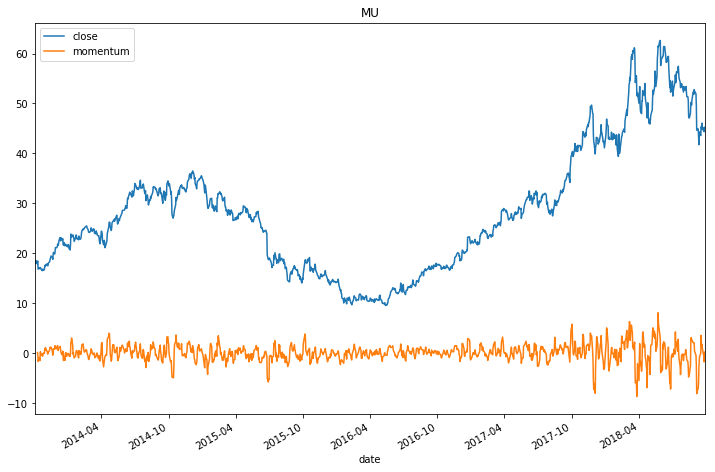

In [9]:
df1 = df.copy()
# https://www.investopedia.com/articles/technical/081501.asp
df1['momentum'] = df1.close - df1.close.shift(4)
df1[['close', 'momentum']].plot(figsize=(12,8), title='MU')

In [10]:
df1.head()

,open,high,low,close,volume,momentum
date,,,,,,
2013-10-03,17.94,18.100,17.37,18.015,58897371,NaN
2013-10-04,18.08,18.545,18.01,18.470,48056969,NaN
2013-10-07,18.77,18.850,18.48,18.485,61944447,NaN
2013-10-08,18.60,18.650,17.73,17.925,57086352,NaN
2013-10-09,18.03,18.450,17.15,18.150,67665565,0.135


# Step 3 - do a regression based on the features, forecast 30-day ahead

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing, cross_validation

#Add Prediction column into dataframe with shifted forecast days
forecast_day = int(30) # Predicting 30 days into future
df['Prediction'] = df[['close']].shift(-forecast_day) # Prediction columns with data shifted 30 units UP
# df.tail(31)


X = np.array(df.drop(['Prediction'], axis=1)) 
X = preprocessing.scale(X) #Scale the data after drop Prediction column
print('X shape after drop Prediction column:', X.shape)

X_predicted = X[-forecast_day:]
X = X[:-forecast_day] #Remove last 30 rows from X
print('X shape after remove last 30 days from X:', X.shape)
print('X_predicted shape:', X_predicted.shape)

y = np.array(df['Prediction'])
y = y[:-forecast_day] #Remove last 30 rows from y
print('y shape:', y.shape)

X shape after drop Prediction column: (1257, 5)
X shape after remove last 30 days from X: (1227, 5)
X_predicted shape: (30, 5)
y shape: (1227,)


C:\Users\StrikeWade\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



In [12]:
#Train test split
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.2)

classifier = LinearRegression()
classifier.fit(X_train, y_train)

accuracy = classifier.score(X_test, y_test)
print('Accuracy score on test set:', accuracy*100)

Accuracy score on test set: 89.9690109716


In [13]:
forecast_prediction = classifier.predict(X_predicted)
print('Forecast prediction 30 days into the future: \n', forecast_prediction)

predictions = classifier.predict(X)
predictions

Forecast prediction 30 days into the future: 
 [ 46.94460107  47.92605754  50.14520997  49.51458001  48.99098773
  50.28571973  51.80754134  51.13065472  50.77865508  53.37240062
  52.0272365   50.68608579  49.24247375  45.39900113  45.89073818
  44.34938582  42.826902    42.10716653  44.99800033  43.94382852
  43.75980116  46.09320322  44.85481014  46.65825656  45.52158714
  45.53001227  44.35346585  44.15595908  45.30704233  45.27964355]


array([ 19.02352396,  19.73441529,  19.73191759, ...,  49.78247212,
        47.38456814,  46.73565162])

# Step 4 - plot (as a line) the regression and expected output, make the plot zoomable

In [14]:
from datetime import datetime, timedelta

# last_date = df_close.iloc[-1].name
# modified_date = last_date + timedelta(days=1)
# date = pd.date_range(last_date, periods=30, freq='D')
# df1 = pd.DataFrame(forecast_prediction, columns=['Forecast'], index=date)
# df_close = df_close.append(df1)
# df_close.tail()

last_date = df.iloc[-1].name
modified_date = last_date + timedelta(days=1)
date = pd.date_range(last_date, periods=30, freq='D')
df1 = pd.DataFrame(forecast_prediction, columns=['Forecast'], index=date)
df = df.append(df1)
df.tail()

,Forecast,Prediction,close,high,low,open,volume
2018-10-23,45.530012,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-24,44.353466,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-25,44.155959,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-26,45.307042,NaN,NaN,NaN,NaN,NaN,NaN
2018-10-27,45.279644,NaN,NaN,NaN,NaN,NaN,NaN


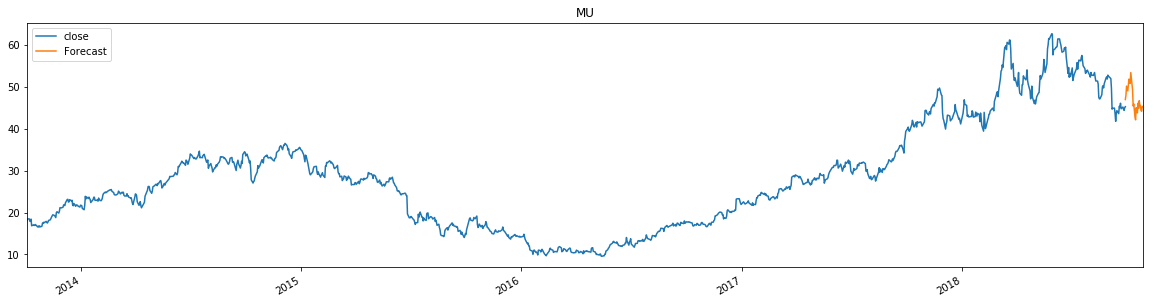

In [15]:
df[['close', 'Forecast']].plot(figsize=(20,5), title='MU')
# df_close['Forecast'].plot()
plt.legend(loc='best')

In [16]:
trace0 = go.Scatter(
    x = df.index,
    y = df['close'],
    name = 'close',
    mode = 'markers',
    marker = dict(size=3)
)

trace1 = go.Scatter(
    x = df.index,
    y = df['Forecast'],
    name = 'Forecast'
)

trace2 = go.Scatter(
    x = df.index,
    y = classifier.predict(X),
    name = 'trend line',
    mode = 'lines',
    line = dict(width=2)
)

data = [trace0, trace1, trace2]

py.iplot(data, filename='basic-line')

In [17]:
df1 = DataReader('MU','iex', start, end)
X = df1['close'].values
y = X

X = [i for i in range(0, len(X))]
X = np.reshape(X, newshape=(len(X), 1))

model = LinearRegression()
model.fit(X, y)

#Calculate trend
trend = model.predict(X)

5y


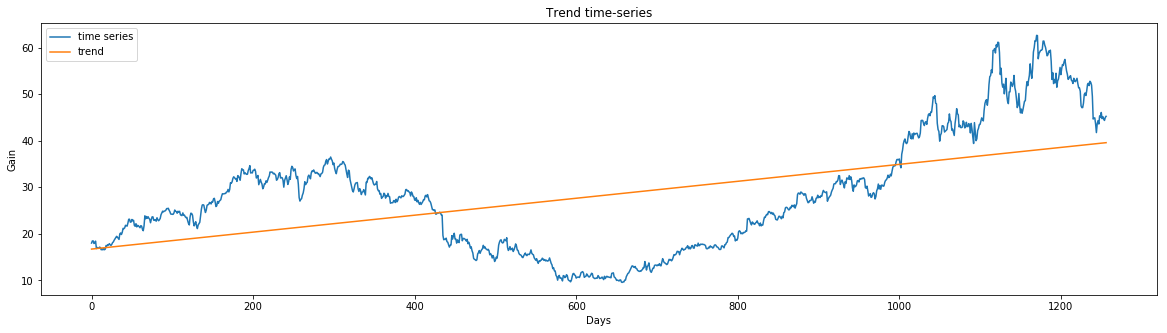

In [18]:
#Plot trend
plt.figure(figsize=(20,5))
plt.plot(y, label='time series')
plt.plot(trend, label='trend')
# plt.plot(df['Forecast'], label='forecast')
plt.xlabel('Days')
plt.ylabel('Gain')
plt.title('Trend time-series')
plt.legend()

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


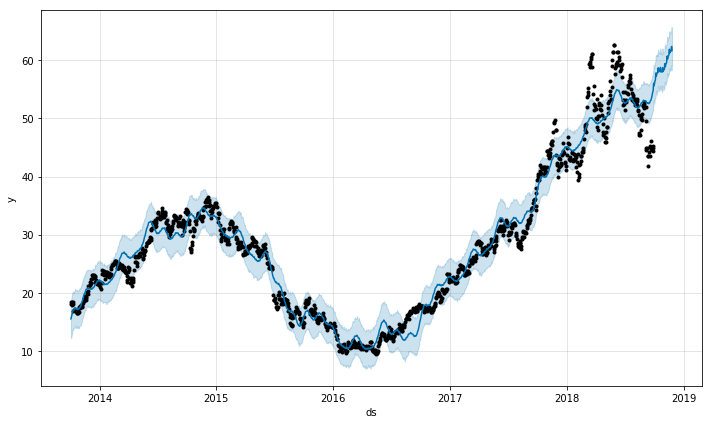

In [19]:
from fbprophet import Prophet

df_close = df[['close']]
df_close = df_close.reset_index()
df_close = df_close.rename(index=str, columns={"index": "ds", "close": "y"})
df_close.head()

m = Prophet()
m.fit(df_close)

future = m.make_future_dataframe(periods=30)
future.tail()

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

fig1 = m.plot(forecast)

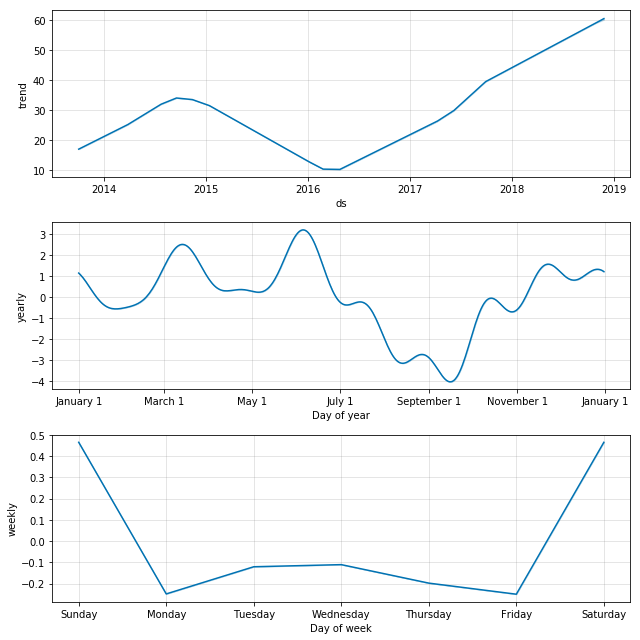

In [20]:
fig2 = m.plot_components(forecast)

C:\Users\StrikeWade\Anaconda3\lib\site-packages\fbprophet\forecaster.py:1425: DeprecationWarning:

This method will be removed in the next version. Please use fbprophet.plot.plot_forecast_component. 



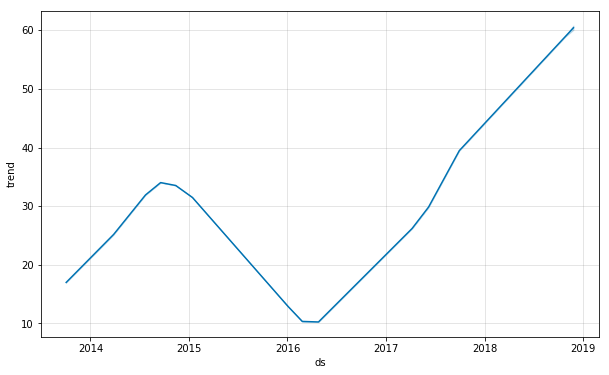

In [21]:
fig3 = m.plot_forecast_component(forecast, 'trend')

In [22]:
forecast.head()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
0,2013-10-03,16.993666,16.993666,16.993666,12.367754,18.650765,-1.473295,-1.473295,-1.473295,0.0,0.0,0.0,-0.197949,-0.197949,-0.197949,-1.275346,-1.275346,-1.275346,15.520371
1,2013-10-04,17.040160,17.040160,17.040160,12.219954,18.841257,-1.320626,-1.320626,-1.320626,0.0,0.0,0.0,-0.250109,-0.250109,-0.250109,-1.070517,-1.070517,-1.070517,15.719534
2,2013-10-07,17.179641,17.179641,17.179641,13.104652,19.902497,-0.798175,-0.798175,-0.798175,0.0,0.0,0.0,-0.248782,-0.248782,-0.248782,-0.549393,-0.549393,-0.549393,16.381466
3,2013-10-08,17.226134,17.226134,17.226134,13.606713,20.035057,-0.534501,-0.534501,-0.534501,0.0,0.0,0.0,-0.120980,-0.120980,-0.120980,-0.413521,-0.413521,-0.413521,16.691633
4,2013-10-09,17.272628,17.272628,17.272628,13.811432,20.244496,-0.409877,-0.409877,-0.409877,0.0,0.0,0.0,-0.110999,-0.110999,-0.110999,-0.298877,-0.298877,-0.298877,16.862751


# Step 5 - add 2 more features from the “Type 2” category of features presented in the paper

In [28]:
df_close = df[['close']]

In [29]:
#Moving average / Running mean
def SMA(series, N):
    s = 0
    result = list(0 for x in series)
    
    for i in range(0, N):
        s += series[i]
        result[i] = s / (i+1)
        
    for i in range(N, len(series)):
        s = s - series[i-N] + series[i]
        result[i] = s / N
        
    return result

def BIAS(series, ma):
    
    bias = list(0 for x in series)
    
    for i in range(0, len(series)):
        bias[i] = ((series[i] - ma[i]) / ma[i]) *100
        
    return bias

In [30]:
df_close1 = df_close.copy()
df_close1 = df_close1.reset_index()

sma = SMA(df_close1.close, 5)

df_SMA = pd.DataFrame({'SMA': sma})
df_close1 = df_close1.join([df_SMA])

In [31]:
bias = BIAS(df_close1.close, df_close1.SMA)

df_BIAS = pd.DataFrame({'BIAS': bias})
df_close1 = df_close1.join([df_BIAS])
df_close1.head()

,index,close,SMA,BIAS
0,2013-10-03,18.015,18.015000,0.000000
1,2013-10-04,18.470,18.242500,1.247088
2,2013-10-07,18.485,18.323333,0.882299
3,2013-10-08,17.925,18.223750,-1.639344
4,2013-10-09,18.150,18.209000,-0.324016


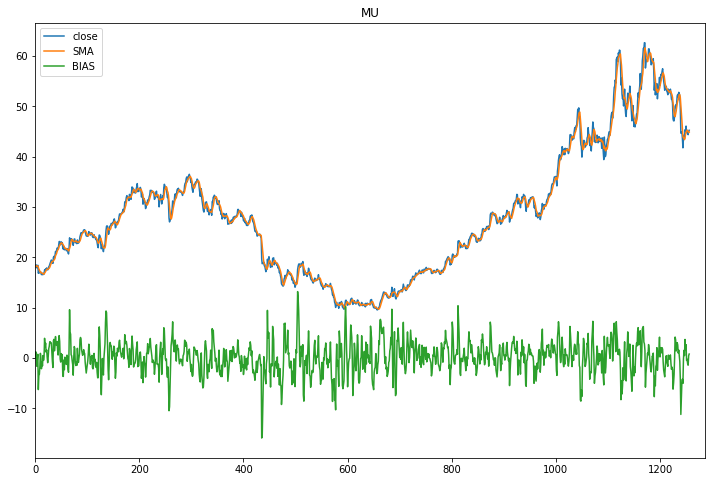

In [32]:
df_close1[['close', 'SMA', 'BIAS']].plot(figsize=(12,8), title='MU')

# Step 6 - design a decision for when to invest and when to sell based on your regression. 
## The model can be naïve, meaning you can create a rule (if .. X .. then .. Y)

In [33]:
signal = pd.DataFrame(data=forecast, columns=['ds','trend','yhat'])
signal.head()

,ds,trend,yhat
0,2013-10-03,16.993666,15.520371
1,2013-10-04,17.040160,15.719534
2,2013-10-07,17.179641,16.381466
3,2013-10-08,17.226134,16.691633
4,2013-10-09,17.272628,16.862751


In [34]:
updown = []
for i in range(0, len(signal)-1):
    if signal.trend[i] > signal.trend[i+1]:
        updown.append('down')
    elif signal.trend[i] < signal.trend[i+1]:
        updown.append('up')
    else:
        updown.append('no')
        
df_updown = pd.DataFrame({'updown': updown})
signal = signal.join([df_updown])
signal.tail()

,ds,trend,yhat,updown
1312,2018-11-22,60.221181,61.591670,up
1313,2018-11-23,60.270703,61.592007,up
1314,2018-11-24,60.320225,62.344626,up
1315,2018-11-25,60.369748,62.369529,up
1316,2018-11-26,60.419270,61.669512,NaN


In [35]:
decision = []
for i in range(0, len(signal)-1):
    if signal.updown[i+1] == 'up':
        decision.append('BUY')
    elif signal.updown[i+1] == 'down':
        decision.append('SELL')
    else:
        decision.append('HOLD')
        
df_decision = pd.DataFrame({'decision': decision})
signal = signal.join([df_decision])
signal.tail()

,ds,trend,yhat,updown,decision
1312,2018-11-22,60.221181,61.591670,up,BUY
1313,2018-11-23,60.270703,61.592007,up,BUY
1314,2018-11-24,60.320225,62.344626,up,BUY
1315,2018-11-25,60.369748,62.369529,up,HOLD
1316,2018-11-26,60.419270,61.669512,NaN,NaN


# Test ARIMA and ARMA model 

## Useful functions

In [36]:
from sklearn.metrics import mean_squared_error
from math import sqrt
from pandas.plotting import autocorrelation_plot

# feature engineering - generate different timestamps
def generate_lag(dataframe, lags):
    lag_df = dataframe.copy()
    
    # Add lag values
    lag_values = [lag_df]
    for i in range(1,(lags + 1)):
        lag_values.append(lag_df.shift(i))
    lag_df = pd.concat(lag_values, axis=1)

    # Rename
    columns = ['t']
    for i in range(1,(lags + 1)):
        columns.append('t-' + str(i))
    lag_df.columns = columns

    # Remove Nan
    lag_df = lag_df[lags:]
    
    return lag_df

# Plot correlation of timestamps
def plot_correlation(dataframe, lags):
    plt.figure(1)
    for i in range(1, (lags + 1)):
        ax = plt.subplot(240 + i)
        ax.set_title('t vs t-' + str(i))
        plt.scatter(x=dataframe['t'].values, y=dataframe['t-'+str(i)].values)

# Compute daily return
def compute_daily_return(df):
    ''' Compute and return the daily return values '''
    
    daily_returns = (df / df.shift(1)) - 1
    
    #Set daily returns for row 0 to 0
    daily_returns.iloc[0, :] = 0
    return daily_returns

#Custom split dataset
def split_dataset(dataset, split_percentage=0.7):
    train_size = int(len(dataset) * split_percentage)
    return dataset[1:train_size], dataset[train_size:]

In [37]:
from statsmodels.tsa.arima_model import ARIMA
import warnings
warnings.filterwarnings("ignore")

def train_ARIMA(train, test, orders):
    history = [x for x in train]
    predictions = list()
    
    for t in range(len(test)):
        model = ARIMA(endog=history, order=orders)
        model_fit = model.fit(disp=0)
        
        y_hat = model_fit.forecast()[0]
        predictions.append(y_hat)
        
        obs = test[t]
        history.append(obs)
    
    return predictions

# p: The number of lag observations included in the model (lag order)
# d: The number of times that the raw observations are differenced (degree of differencing)
# q: The size of the moving average window (order of moving average)

def gridsearch_ARIMA(train, test, p_values, d_values, q_values):
    best_rmse = float('inf')
    best_orders = None
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                orders = (p,d,q)
                try:
                    predictions = train_ARIMA(train, test, orders)
                    rmse = sqrt(mean_squared_error(test, predictions))
                    print ('Currently testing (p,d,q) =', orders, '----- rmse =', rmse)
                    
                    # Find best rmse
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_orders = orders
                except:
                    continue

    return best_orders, best_rmse

C:\Users\StrikeWade\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



In [38]:
from statsmodels.tsa.arima_model import ARMA
import warnings
warnings.filterwarnings("ignore")

def train_ARMA(train, test, orders):
    history = [x for x in train]
    predictions = list()
    
    for t in range(len(test)):
        model = ARMA(endog=history, order=orders)
        model_fit = model.fit(disp=0)
        
        y_hat = model_fit.forecast()[0]
        predictions.append(y_hat)
        
        obs = test[t]
        history.append(obs)
    
    return predictions

# p: The number of lag observations included in the model (lag order)
# q: The size of the moving average window (order of moving average)

def gridsearch_ARMA(train, test, p_values, q_values):
    best_rmse = float('inf')
    best_orders = None
    
    for p in p_values:
            for q in q_values:
                orders = (p,q)
                try:
                    predictions = train_ARMA(train, test, orders)
                    rmse = sqrt(mean_squared_error(test, predictions))
                    print ('Currently testing (p,q) =', orders, '----- rmse =', rmse)
                    
                    # Find best rmse
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_orders = orders
                except:
                    continue

    return best_orders, best_rmse

In [39]:
df2 = DataReader('MU','iex', start, end)
df2.head()

#Choose close column for predictions
df_close = df2[['close']]
df_close.head()

5y


,close
date,
2013-10-03,18.015
2013-10-04,18.470
2013-10-07,18.485
2013-10-08,17.925
2013-10-09,18.150


In [41]:
#Simple Normalized data
df_close = df_close / df_close.iloc[0, :]
df_close.head()

,close
date,
2013-10-03,1.000000
2013-10-04,1.025257
2013-10-07,1.026089
2013-10-08,0.995004
2013-10-09,1.007494


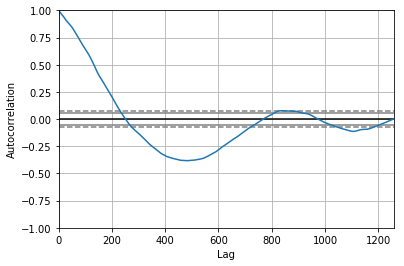

In [42]:
#Autocorrelation graph for df_close
autocorrelation_plot(df_close.close)

In [43]:
MU_stock = generate_lag(df_close.close, 7)
MU_stock.head()

,t,t-1,t-2,t-3,t-4,t-5,t-6,t-7
date,,,,,,,,
2013-10-14,0.947544,0.934777,1.023036,1.007494,0.995004,1.026089,1.025257,1.000000
2013-10-15,0.939217,0.947544,0.934777,1.023036,1.007494,0.995004,1.026089,1.025257
2013-10-16,0.941438,0.939217,0.947544,0.934777,1.023036,1.007494,0.995004,1.026089
2013-10-17,0.951707,0.941438,0.939217,0.947544,0.934777,1.023036,1.007494,0.995004
2013-10-18,0.945268,0.951707,0.941438,0.939217,0.947544,0.934777,1.023036,1.007494


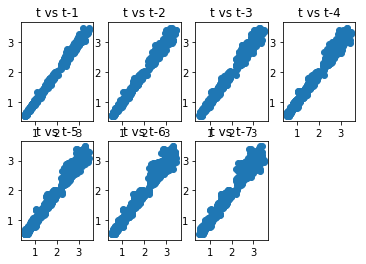

In [44]:
plot_correlation(MU_stock, 7)

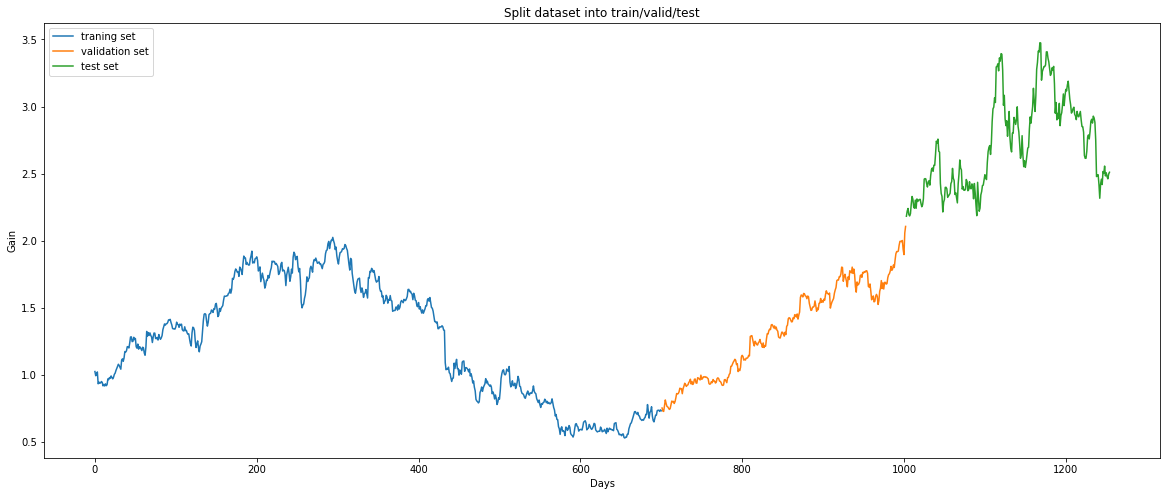

In [45]:
dataset = df_close.close.values

#Split train-test
train_valid, test = split_dataset(dataset, split_percentage=0.8)

#Split train-validation
train, valid = split_dataset(train_valid, split_percentage=0.7)

# X_train, y_train = train_set[:, 1:], train_set[:, 0]
# X_valid, y_valid = valid_set[:, 1:], valid_set[:, 0]
# X_test, y_test = test_set[:, 1:], test_set[:, 0]

plt.figure(figsize=(20,8))
plt.plot(train, label='traning set')
plt.plot([None]*len(train) + [x for x in valid], label='validation set')
plt.plot([None]*(len(train) + len(valid)) + [x for x in test], label='test set')
plt.xlabel('Days')
plt.ylabel('Gain')
plt.title('Split dataset into train/valid/test')
plt.legend()

## ARIMA model forecasting

In [46]:
p_values = range(3)
d_values = range(3)
q_values = range(3)

In [47]:
# Find best orders (p,d,q)
# best_orders, best_rmse = gridsearch_ARIMA(train, valid, p_values, d_values, q_values)

# print('Best order (p,d,q): ', best_orders)
# print('Validation rmse: %.3f' % best_rmse)

** ARIMA best_order is: (0, 1, 0) **

Test rmse: 0.121


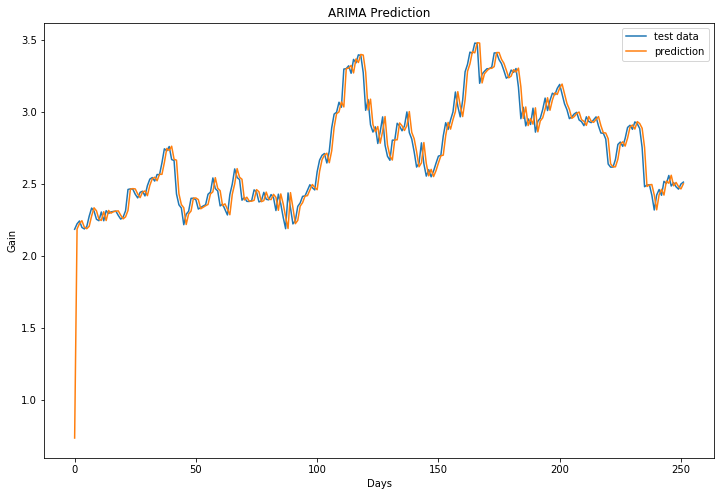

In [48]:
best_orders = (0,1,0)

#Predict based on best orders
predictions = train_ARIMA(train, test, best_orders)

#Evaluate
rmse = sqrt(mean_squared_error(test, predictions))
print('Test rmse: %.3f' % rmse)

#Plotting
plt.figure(figsize=(12,8))
plt.plot(test, label='test data')
plt.plot(predictions, label='prediction')
plt.title('ARIMA Prediction')
plt.xlabel('Days')
plt.ylabel('Gain')
plt.legend()

## ARMA model forecasting

In [49]:
p_values = range(3)
q_values = range(3)

In [50]:
# Find best orders (p,q)
# best_orders, best_rmse = gridsearch_ARMA(train, valid, p_values, q_values)

# print('Best order (p,q): ', best_orders)
# print('Validation rmse: %.3f' % best_rmse)

** ARMA best_order is: (1, 0) **

Test rmse: 0.121


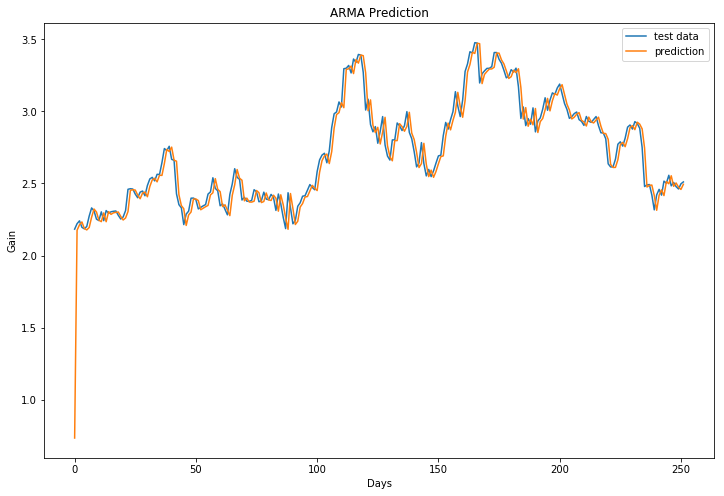

In [51]:
best_orders = (1, 0)

#Predict based on best orders
predictions = train_ARMA(train, test, best_orders)

#Evaluate
rmse = sqrt(mean_squared_error(test, predictions))
print('Test rmse: %.3f' % rmse)

#Plotting
plt.figure(figsize=(12,8))
plt.plot(test, label='test data')
plt.plot(predictions, label='prediction')
plt.title('ARMA Prediction')
plt.xlabel('Days')
plt.ylabel('Gain')
plt.legend()